# Brain Tumor Detection

### Necessary imports

Link to the data set: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import Image

# Tensorflow imports
import tensorflow as tf
import tensorflow_hub as hub

# Sklearn imports
from sklearn.model_selection import train_test_split


### Preparing the data

In [5]:
def create_data_set():
  """
  Creates pandas dataframe that contains image path and
  classification if on image is tumor or not.
  """
  path = "/content/drive/MyDrive/Colab Notebooks/brain_tumor_dataset/no/"
  images_false = os.listdir(path)
  images_false = [path + image for image in images_false]
  dataframe = pd.DataFrame({"Image_path": images_false,
                            "Is_tumor": False})

  path = "/content/drive/MyDrive/Colab Notebooks/brain_tumor_dataset/yes/"
  images_true = os.listdir(path)
  images_true = [path + image  for image in images_true]
  dataframe_true = pd.DataFrame({"Image_path": images_true,
                                 "Is_tumor": True},)

  dataframe = dataframe.append(dataframe_true, ignore_index = True)
  return dataframe

df_complete = create_data_set()

<ipython-input-5-d2beb411dfda>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataframe = dataframe.append(dataframe_true, ignore_index = True)


In [6]:
df_complete

,Image_path,Is_tumor
0,/content/drive/MyDrive/Colab Notebooks/brain_t...,False
1,/content/drive/MyDrive/Colab Notebooks/brain_t...,False
2,/content/drive/MyDrive/Colab Notebooks/brain_t...,False
3,/content/drive/MyDrive/Colab Notebooks/brain_t...,False
4,/content/drive/MyDrive/Colab Notebooks/brain_t...,False
...,...,...
248,/content/drive/MyDrive/Colab Notebooks/brain_t...,True
249,/content/drive/MyDrive/Colab Notebooks/brain_t...,True
250,/content/drive/MyDrive/Colab Notebooks/brain_t...,True
251,/content/drive/MyDrive/Colab Notebooks/brain_t...,True


In [7]:
df_complete.Image_path[0]

'/content/drive/MyDrive/Colab Notebooks/brain_tumor_dataset/no/11 no.jpg'

In [8]:
def preprocess_image(image_path):
  """
  Converts image into tensor.
  """
  image_path = tf.reshape(image_path, [])
  img = tf.io.read_file(image_path)
  img = tf.io.decode_jpeg(img, channels = 3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = tf.image.resize(img, [224, 224])
  return img

def get_image_label(image, label):
  """
  Returns image and label in tensor format.
  """
  image = preprocess_image(image)
  return image, label


In [9]:
df_temp = df_complete
df_temp = df_temp.sample(frac = 1)

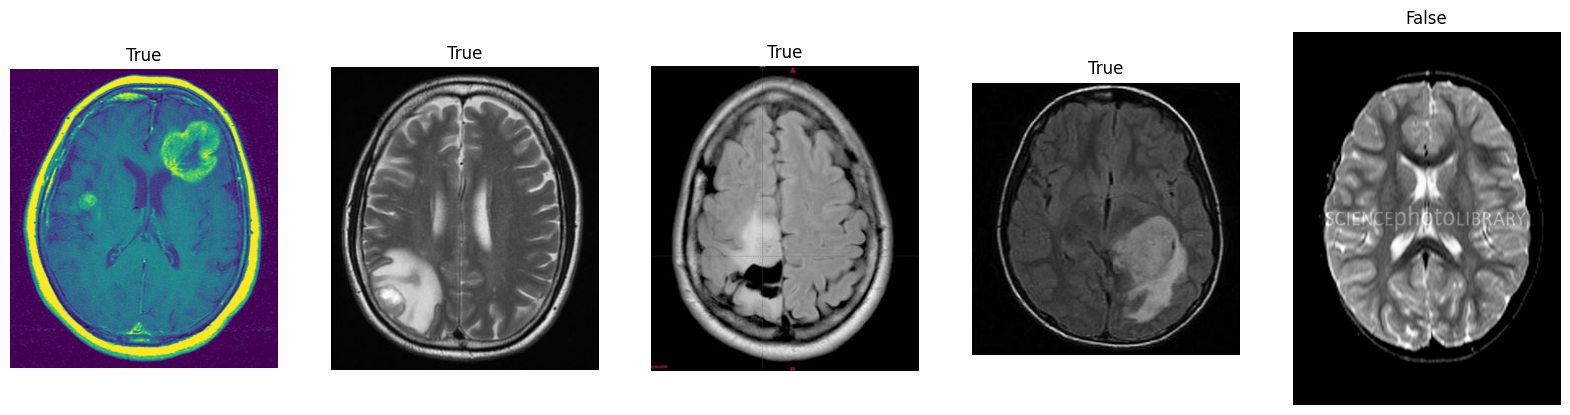

In [10]:
plt.figure(figsize = (20, 10))
i = 1
for x in range(0, 6):
  plt.subplot(1, 5, i)
  z = plt.imread(df_temp.Image_path.iloc[x])
  plt.imshow(z)
  plt.title(df_temp.Is_tumor.iloc[x])
  plt.axis("off")
  i += 1
  if i >= 6:
    i -= 1

In [11]:
X = df_temp.drop("Is_tumor", axis = 1)
y = df_temp["Is_tumor"]

In [12]:
X_test, y_test = X[:20], y[:20]
X_train, X_val, y_train, y_val = train_test_split(X[20:], y[20:], test_size = 0.2)

In [13]:
BATCH_SIZE = 32
NUM_EPOCHS = 64
def create_batch(X, y = None, is_train = False, is_val = False, is_test = False):
  """
  Creates data batches
  """
  if is_train:
    dataset = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                                  tf.constant(y)))
    dataset = dataset.map(get_image_label)
    dataset_batch = dataset.batch(BATCH_SIZE)
    return dataset_batch
  if is_val:
    dataset = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                                  tf.constant(y)))
    dataset = dataset.map(get_image_label)
    dataset_batch = dataset.batch(BATCH_SIZE)
    return dataset_batch
  if is_test:
    dataset = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                                  tf.constant(y)))
    dataset = dataset.map(get_image_label)
    dataset_batch = dataset.batch(BATCH_SIZE)
    return dataset_batch

In [14]:
train_data = create_batch(X_train, y_train, is_train = True)
valid_data = create_batch(X_val, y_val, is_val = True)
test_data = create_batch(X_test, y_test, is_test = True)

In [15]:
train_data.element_spec

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.bool, name=None))

### Creating model/callbacks/optimizers

In [39]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",
                                                  patience = 3,
                                                  verbose = 1)
tensorboard = tf.keras.callbacks.TensorBoard(log_dir = "/content/drive/MyDrive/Colab Notebooks/brain_tumor_detection/logs")

In [31]:
def build_model(INPUT_SHAPE = [None, 224, 224, 3], OUTPUT_SHAPE = 1):
  """
  Creates and builds a model
  """
  model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v2_101/classification/5"),
    tf.keras.layers.Dense(units = OUTPUT_SHAPE,
                          activation = "sigmoid")
  ])

  model.compile(
      loss = tf.keras.losses.BinaryCrossentropy(),
      optimizer = tf.keras.optimizers.Adam(),
      metrics = ["accuracy"]
  )

  model.build(INPUT_SHAPE)
  return model

model = build_model()

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              44677609  
                                                                 
 dense (Dense)               (None, 1)                 1002      
                                                                 
Total params: 44678611 (170.44 MB)
Trainable params: 1002 (3.91 KB)
Non-trainable params: 44677609 (170.43 MB)
_________________________________________________________________


### Training model

In [19]:
model.fit(x = train_data,
          epochs = NUM_EPOCHS,
          validation_data = valid_data,
          validation_freq = 1,
          callbacks = [early_stopping, tensorboard])

Epoch 1/64
6/6 [==============================] - 31s 2s/step - loss: 1.0505 - accuracy: 0.4731 - val_loss: 0.6985 - val_accuracy: 0.6383
Epoch 2/64
6/6 [==============================] - 1s 205ms/step - loss: 0.7148 - accuracy: 0.5806 - val_loss: 0.5239 - val_accuracy: 0.7234
Epoch 3/64
6/6 [==============================] - 2s 266ms/step - loss: 0.5305 - accuracy: 0.7366 - val_loss: 0.3997 - val_accuracy: 0.8298
Epoch 4/64
6/6 [==============================] - 1s 197ms/step - loss: 0.4222 - accuracy: 0.7849 - val_loss: 0.3467 - val_accuracy: 0.8511
Epoch 5/64
6/6 [==============================] - 1s 200ms/step - loss: 0.3626 - accuracy: 0.8441 - val_loss: 0.3198 - val_accuracy: 0.8298
Epoch 6/64
6/6 [==============================] - 1s 202ms/step - loss: 0.3311 - accuracy: 0.8602 - val_loss: 0.2926 - val_accuracy: 0.8723
Epoch 7/64
6/6 [==============================] - 2s 290ms/step - loss: 0.3036 - accuracy: 0.8602 - val_loss: 0.2790 - val_accuracy: 0.8723
Epoch 8/64
6/6 [======

### Evaluating a model

In [42]:
model.evaluate(test_data)

1/1 [==============================] - 4s 4s/step - loss: 1.1484 - accuracy: 0.3500


[1.1484463214874268, 0.3499999940395355]

### Saving model

In [43]:
model.save("/content/drive/MyDrive/Colab Notebooks/brain_tumor_dataset/")